## Intro

Here, we will see the extrapolation potential - and problems - of neural networks. We have trained two simple networsk with one, 128-neuron hidden layer, to imitate the transformation  $x + 10$ on the dataset $x ~ N(0, 1)$. We'll see how well they perform outside that domain. (The only difference between them is the nonlinearity - one ELU, one ReLU).

In [1]:
from utils import *
from simple import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'extrapolation10plus128'

hidden=128
datasize, learning_rate, epochs = get_params(fname)
print([datasize, learning_rate, epochs])

Le, Lre = get_losses(fname)

e, re = get_models(fname)

datasize,learning_rate,epochs

[2048, 0.001, 50000]


## Learning

First, let's take a look at the learning curves, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

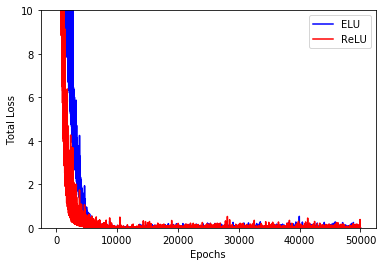

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(Le)+1), Le, 'b-', label="ELU")
plt.plot(range(1, len(Le)+1), Lre, 'r-', label="ReLU")
plt.ylim([0, 10])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend()

fig

It appears that both losses have plateaued. Where?

In [3]:
print("ELU")
print(Le[-10:])
print("ReLU")
print(Lre[-10:])

ELU
[0.0006417287513613701, 0.0007516485638916492, 0.0009692545281723142, 0.0012776801595464349, 0.001552655128762126, 0.002102501690387726, 0.0028973273001611233, 0.0038388774264603853, 0.004958527162671089, 0.006664926186203957]
ReLU
[0.0021529230289161205, 0.001080494374036789, 0.00033105784677900374, 0.0006654462195001543, 0.0015027194749563932, 0.0013499694177880883, 0.0004981043166480958, 0.0003484326880425215, 0.000594377052038908, 0.0007210514741018414]


Great. Now, let's examin the behavior far from the training distribution

## Plots of The Function

In [3]:
# Get data and ground truth

x = np.arange(-10, 10, 0.01)
y = np.arange(-10, 10, 0.01)+10

In [4]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

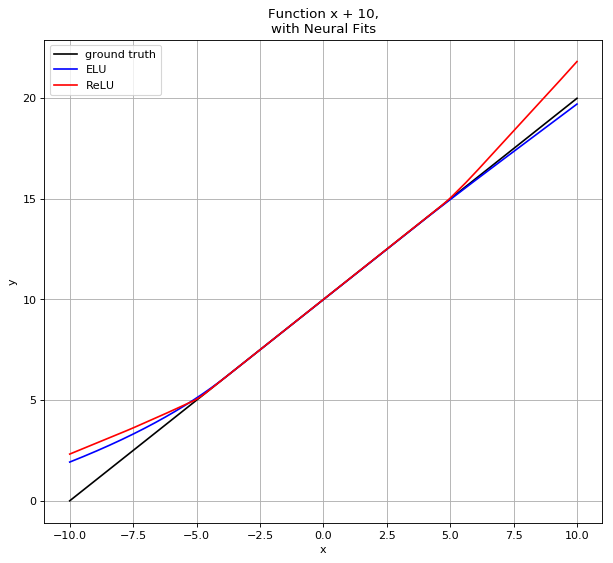

In [6]:
# Plot output

fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.grid(True)

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title('Function x + 10,\nwith Neural Fits')

fig

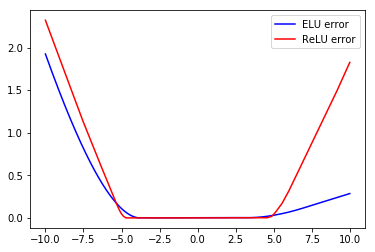

In [7]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

Ther seems to be a significant error even here, for both networks, even though ReLU is far closer.

Let's look at the internals of these networks in order to see where we can expect further errors.

In [8]:
print("ReLU")

print(re.fc1.weight)
print(re.fc1.bias)
print(-re.fc1.bias.view(-1, 1)/re.fc1.weight)

print("\n\n#######################\n\n")

print(re.fc2.weight)
print(re.fc2.bias)

ReLU
Parameter containing:
tensor([[ 0.9235],
        [-0.0972],
        [-1.0125],
        [ 0.2112],
        [ 0.4006],
        [ 0.0771],
        [-0.9432],
        [-0.8587],
        [ 0.1944],
        [-0.7242],
        [-0.0598],
        [-0.9915],
        [ 0.9831],
        [ 0.6036],
        [-0.8051],
        [-0.6522],
        [ 0.8339],
        [-0.8861],
        [-0.3582],
        [-0.6381],
        [ 0.4040],
        [-0.0604],
        [ 0.3149],
        [ 1.0635],
        [-0.4575],
        [-0.0693],
        [ 0.8072],
        [-0.8929],
        [-0.2303],
        [-0.1402],
        [-0.3753],
        [-0.5980],
        [ 1.0717],
        [-0.2623],
        [-0.7676],
        [ 0.4804],
        [-0.9360],
        [-0.5542],
        [ 0.3927],
        [-0.5238],
        [-0.0670],
        [ 0.4764],
        [ 0.7102],
        [ 0.1402],
        [ 0.0654],
        [ 0.0085],
        [-0.6234],
        [-0.0828],
        [-0.5133],
        [-0.5998],
        [-0.0281],
    

Based on $ - b / w$, we see that between $-100$ and $+100$, we should scroll past all the "elbows" of the ReLU functions. What about the ELU?

In [9]:
print("ELU")

print(e.fc1.weight)
print(e.fc1.bias)
print(-e.fc1.bias.view(-1, 1)/e.fc1.weight)

print("\n\n#######################\n\n")

print(e.fc2.weight)
print(e.fc2.bias)

ELU
Parameter containing:
tensor([[ 0.0914],
        [ 0.5447],
        [ 0.0388],
        [ 1.2667],
        [ 0.1668],
        [ 0.4395],
        [ 0.2885],
        [ 0.2208],
        [-0.3101],
        [-0.6476],
        [-0.5236],
        [ 0.0907],
        [-1.0892],
        [ 0.3752],
        [-0.2191],
        [ 0.0966],
        [-0.4184],
        [-0.3603],
        [ 0.0825],
        [ 0.2451],
        [-1.2118],
        [-0.8955],
        [ 0.2430],
        [-0.2003],
        [ 0.2992],
        [-0.0197],
        [ 0.2228],
        [ 0.0935],
        [-1.1057],
        [-0.0792],
        [ 0.6122],
        [ 0.0437],
        [ 0.5636],
        [ 0.1272],
        [-0.6348],
        [-0.2067],
        [-0.1661],
        [ 0.6603],
        [-0.3372],
        [-0.0903],
        [-0.2375],
        [ 0.7708],
        [ 0.8484],
        [-0.7808],
        [ 0.3843],
        [ 0.0551],
        [-0.2681],
        [ 0.2099],
        [-0.1554],
        [ 1.1138],
        [ 0.1384],
     

ELU, up to $1000$. Let's go to $100000$, to appreciate the behavior at the asymptotes.

In [10]:
# Get data and ground truth

x = np.arange(-100000, 100000, 100.)
y = np.arange(-100000, 100000, 100.)+10

In [11]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

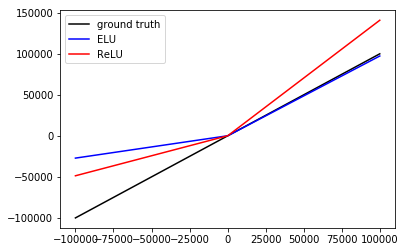

In [12]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

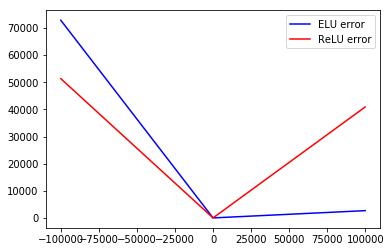

In [13]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

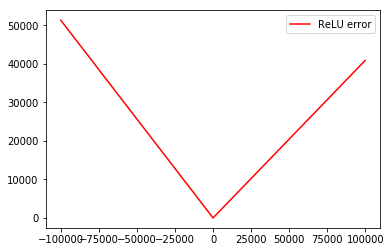

In [14]:
# Focus only on ReLU

fig = plt.figure()

plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

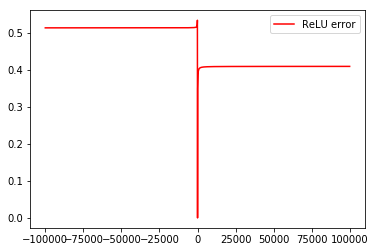

In [15]:
# Focus only on ReLU

fig = plt.figure()

plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2)/abs(y), 'r-', label="ReLU error")

plt.legend()

fig

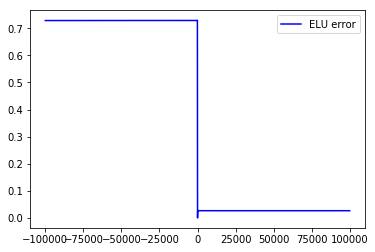

In [16]:
# Focus only on ELU

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2)/abs(y), 'b-', label="ELU error")

plt.legend()

fig

## Concluding Thoughts

Both of these diverge from reality in the negative direction. Even though this is a simple equation - $y = x + 10$ - and even though it lies well within the domain of the ReLU network - we can write $y = 10 + ReLU(x) - ReLU(-x)$ - extrapolation fails.